In [ ]:
pip install pyfim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.3/357.3 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyfim: filename=pyfim-6.28-cp310-cp310-linux_x86_64.whl size=644241 sha256=0bc2f9ab5e03ecd286b5da1ae0698d02ac9e639ed751fde705e802f01ee796ed
  Stored in directory: /root/.cache/pip/wheels/96/0a/b3/c877bfa85c4cfe1baf3de4a89e1949382be09de5eabe49314f
Successfully built pyfim


In [ ]:
pip install fuzzywuzzy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from fim import arules, apriori, fpgrowth
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Load the data
df = pd.read_csv('https://raw.githubusercontent.com/jinzalabim/DATA102-Final-Project/main/anime-dataset-2023-unknownsremoved.csv')
df

,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Source,Duration,Duration (mins),Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,33187,Katsudou Shashin,UNKNOWN,æ´»å‹•å†™çœŸ,5.46,UNKNOWN,A young boy dressed in sailor attire and a bri...,Movie,1,Not available,...,Original,3 sec,0,G - All Ages,10898,6792,23,4458,7548,https://cdn.myanimelist.net/images/anime/1891/...
1,38058,Oi-san to 40 no Monogatari,UNKNOWN,ã‚ªã‚¤ã•ã‚“ã¨40ã®ç‰©èªž,5.45,Slice of Life,Fourty shorts featuring a delightfully chubby ...,ONA,41,"Mar 26, 2018 to Sep 19, 2018",...,Original,6 sec per ep,0,G - All Ages,10942,17209,0,103,301,https://cdn.myanimelist.net/images/anime/1760/...
2,41097,Motto Shitte Fukushima!,UNKNOWN,ã‚‚ã£ã¨ çŸ¥ã£ã¦ ãµãã—ã¾ï¼,UNKNOWN,Slice of Life,Tourism promotional videos for the Fukushima P...,ONA,84,"Feb 18, 2019 to Jan 17, 2020",...,Original,6 sec per ep,0,G - All Ages,18287,19602,0,UNKNOWN,158,https://cdn.myanimelist.net/images/anime/1711/...
3,53291,Terada Mokei Ã— Pocari Sweat,UNKNOWN,ãƒ†ãƒ©ãƒ€ãƒ¢ã‚±ã‚¤ Ã— ãƒã‚«ãƒªã‚¹ã‚¨ãƒƒãƒˆ,UNKNOWN,Slice of Life,Genki-kun's life as a thirsty Japanese salaryman.,ONA,9,"Jun 13, 2013 to Sep 24, 2013",...,Original,6 sec per ep,0,G - All Ages,12887,22274,0,UNKNOWN,58,https://cdn.myanimelist.net/images/anime/1844/...
4,32294,Ai (ONA),UNKNOWN,æ„›,2.63,Romance,The circumstances responsible for the person's...,ONA,1,10-Aug-12,...,Original,7 sec,0,G - All Ages,12693,8440,8,2883,4339,https://cdn.myanimelist.net/images/anime/3/774...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24236,54996,Akuyaku Mahou Shoujo Midoro,UNKNOWN,æ‚ªå½¹é­”æ³•å°‘å¥³ãƒŸãƒ‰ãƒ­,UNKNOWN,"Action, Fantasy",A magical girl who has become a villain and an...,ONA,1,12-May-18,...,Original,9 min,9,PG-13 - Teens 13 or older,14513,22670,0,UNKNOWN,52,https://cdn.myanimelist.net/images/anime/1837/...
24237,55093,Li Shi Zhentan Shiwusuo: A Day in Lungmen - Li...,Lee's Detective Agency: A Holiday of Two Hours,é²¤æ°ä¾¦æŽ¢äº‹åŠ¡æ‰€ ä¸¤å°æ—¶å‡æœŸ,6.09,"Comedy, Mystery","A banquet was planned for honored guests, ever...",ONA,1,22-Apr-23,...,Game,9 min,9,PG-13 - Teens 13 or older,8412,13727,0,221,717,https://cdn.myanimelist.net/images/anime/1901/...
24238,55464,"Nee, Koko ni Iru.",UNKNOWN,ã­ãˆã€ã“ã“ã«å±…ã‚‹ã€‚,UNKNOWN,Avant Garde,An experimental film by Takahiro Shibata.,Movie,1,2016,...,Original,9 min,9,R - 17+ (violence & profanity),18454,24511,0,UNKNOWN,35,https://cdn.myanimelist.net/images/anime/1463/...
24239,55550,On Time Off Time,On Time Off Time,On Time Off Time,UNKNOWN,Avant Garde,The juxtaposed movements resonate with each ot...,Movie,1,2020,...,Original,9 min,9,PG-13 - Teens 13 or older,18680,24673,0,UNKNOWN,25,https://cdn.myanimelist.net/images/anime/1112/...


# Data Preprocessing

In [ ]:
#Unknown Values
df.replace('UNKNOWN', np.nan, inplace=True)
df.drop(columns=['Image URL'], inplace=True)


In [ ]:
# Correct text encoding issues
df['Name'] = df['Name'].str.replace('[^\x00-\x7F]+', '', regex=True)
df['Other name'] = df['Other name'].str.replace('[^\x00-\x7F]+', '', regex=True)

In [ ]:
numeric_cols = ['Score', 'Rank', 'Popularity', 'Favorites', 'Scored By', 'Members', 'Duration (mins)']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [ ]:
# function to find the closest anime by 'Popularity' and impute missing values
def impute_values(df):
    df_copy = df.copy()
    for index, row in df.iterrows():
        if pd.isna(row['Score']) or pd.isna(row['Scored By']) or pd.isna(row['Rank']):
            closest_index = (df['Popularity'] - row['Popularity']).abs().argsort()[1]
            closest_anime = df.iloc[closest_index]
            df_copy.at[index, 'Score'] = closest_anime['Score']
            df_copy.at[index, 'Scored By'] = closest_anime['Scored By']
            df_copy.at[index, 'Rank'] = closest_anime['Rank']
    return df_copy

In [ ]:
df = impute_values(df)

## Fixing Categorical Data

I did this so that the categorical columns 'Type' and 'Rating' are converted into a one-hot encoded format ++ the original categorical columns are removed and replaced with the above

In [ ]:
categorical_cols = ['Type', 'Rating']
one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_features = one_hot_encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=one_hot_encoder.get_feature_names_out(categorical_cols))
df = pd.concat([df, encoded_df], axis=1)
df.drop(columns=categorical_cols, inplace=True)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Preprocess Synopsis
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
synopsis_tfidf = vectorizer.fit_transform(df['Synopsis'].fillna(''))
synopsis_df = pd.DataFrame(synopsis_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

## Data Aggregation

In [ ]:
#Fix numerical columns
numerical_cols = ['Score', 'Rank', 'Popularity', 'Favorites', 'Scored By', 'Members', 'Duration (mins)']
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(df[numerical_cols])
normalized_df = pd.DataFrame(normalized_features, columns=numerical_cols)

In [ ]:
# Process Genres column into multiple binary columns
df['Genres'] = df['Genres'].fillna('')
genres = df['Genres'].str.get_dummies(sep=', ')

In [ ]:
# Combine all features into a single dataframe
processed_df = pd.concat([df[['anime_id', 'Name']], encoded_df, normalized_df, genres, synopsis_df], axis=1)

print(processed_df.head())
print(df.describe())

   anime_id                        Name  Type_Movie  Type_Music  Type_ONA  \
0     33187            Katsudou Shashin         1.0         0.0       0.0   
1     38058  Oi-san to 40 no Monogatari         0.0         0.0       1.0   
2     41097     Motto Shitte Fukushima!         0.0         0.0       1.0   
3     53291  Terada Mokei  Pocari Sweat         0.0         0.0       1.0   
4     32294                    Ai (ONA)         0.0         0.0       1.0   

   Type_OVA  Type_Special  Type_TV  Type_nan  Rating_G - All Ages  ...  women  \
0       0.0           0.0      0.0       0.0                  1.0  ...    0.0   
1       0.0           0.0      0.0       0.0                  1.0  ...    0.0   
2       0.0           0.0      0.0       0.0                  1.0  ...    0.0   
3       0.0           0.0      0.0       0.0                  1.0  ...    0.0   
4       0.0           0.0      0.0       0.0                  1.0  ...    0.0   

   work  working  works  world      year  years   

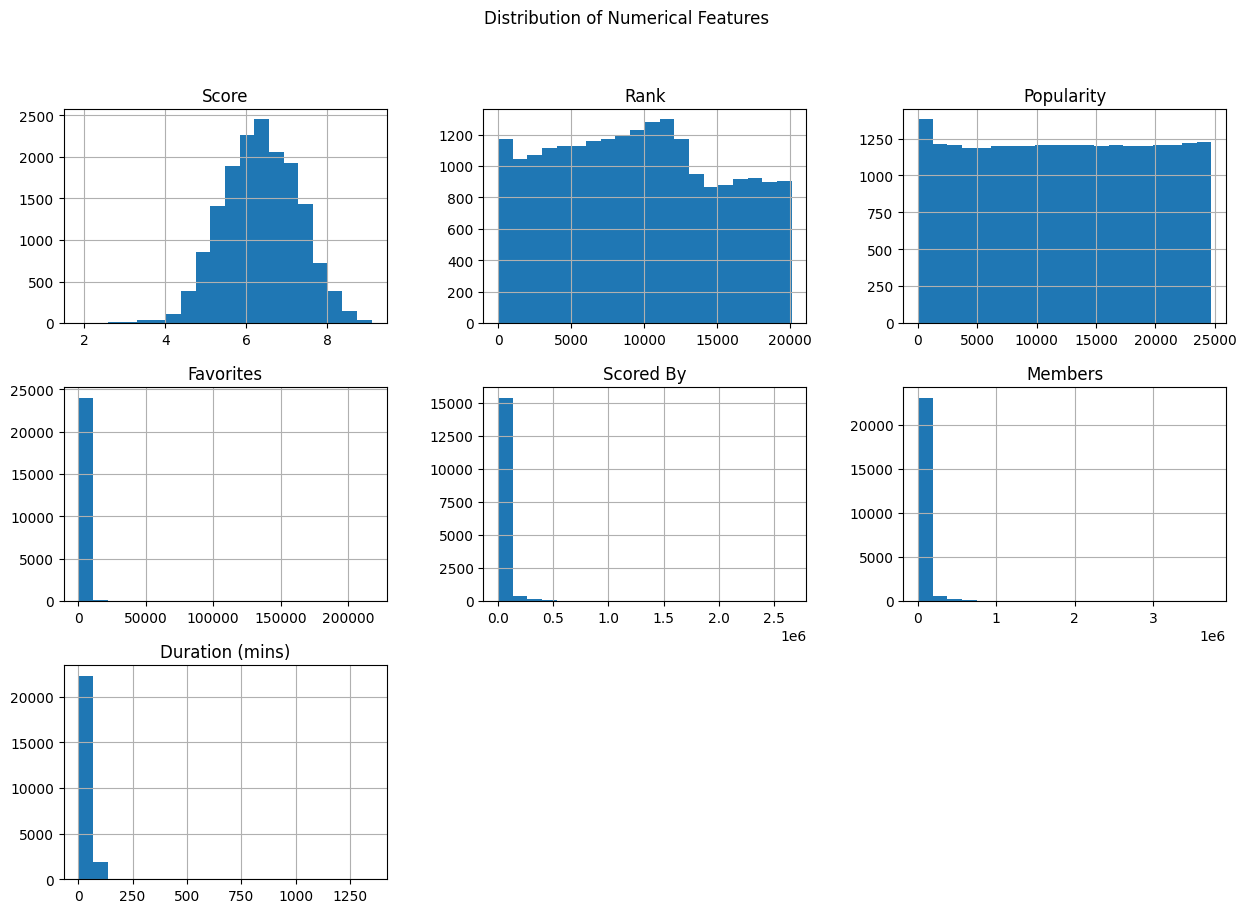

In [ ]:
#Distribution of Numerical Features
numerical_cols = ['Score', 'Rank', 'Popularity', 'Favorites', 'Scored By', 'Members', 'Duration (mins)']
df[numerical_cols].hist(bins=20, figsize=(15, 10))
plt.suptitle('Distribution of Numerical Features')
plt.show()

<ipython-input-16-4ecf55077d4d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tfidf_feature_importance.values, y=tfidf_feature_importance.index, palette='viridis')


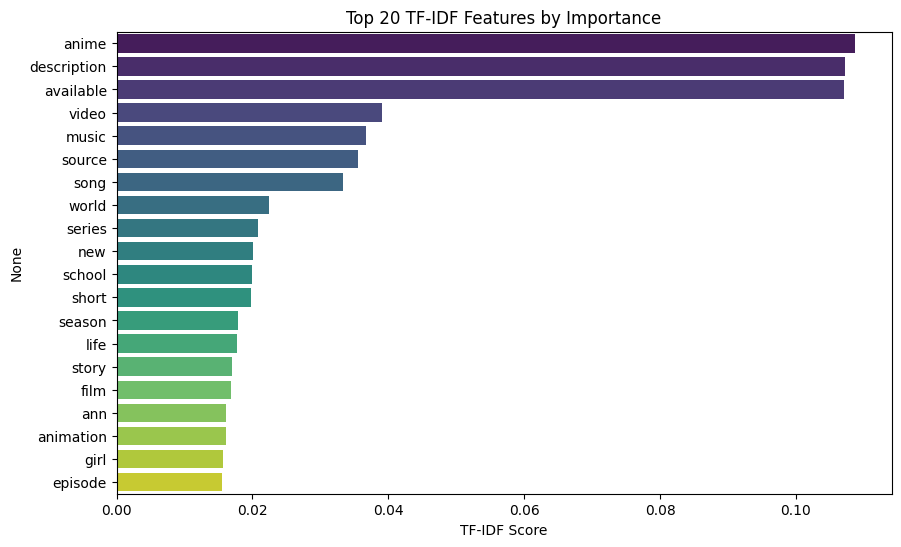

In [ ]:
#TF-IDF Feature Analysis
tfidf_feature_importance = synopsis_df.mean().sort_values(ascending=False).head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=tfidf_feature_importance.values, y=tfidf_feature_importance.index, palette='viridis')
plt.title('Top 20 TF-IDF Features by Importance')
plt.xlabel('TF-IDF Score')
plt.show()

In case we need EDA for Distribution for Categorical Features:



```
#Distribution of Categorical Features
categorical_features = one_hot_encoder.get_feature_names_out(categorical_cols)
for col in categorical_features:
    sns.countplot(y=df[col], palette="viridis")
    plt.title(f'Distribution of {col}')
    plt.show()
```

